# Ising Model Bot Detection

This notebook lets you detect bots in a retweet network using the Ising model algorithm from the paper "Detecting Bots and Assessing Their Impact in Social Networks" https://arxiv.org/abs/1810.12398.  

You will need a retweet graph saved as a networkx object and the helper file networkClassifierHELPER.py and the file ioHELPER.py

In [1]:
import os
import sys
import math
import datetime, time
import random
import numpy as np
import networkx as nx
import sqlite3,sys,os,string
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from scipy.sparse import csc_matrix

from networkClassifierHELPER import *


## Load Retweet  graph

path_data = folder where the retweet graph file is

Gretweet = retweet graph networkx DiGraph object.  

The format of the edges is (u,v,$weight$).  
This means u retweeted v $weight$ times.

Another way to view this is a node's out-degree is the number of nodes it retweeted, a node's in-degree is the number of people who retweet it.
We expect dout to be large for bots, din to be large for popular humans.

In [32]:
path_data = "C://Users//Zlisto//Dropbox (Personal)//MIDAC//BotDetection//Pizzagate//"
   
fname_Gretweet = path_data + "Gretweet_pizzagate.gpickle"
Gretweet = nx.read_gpickle(fname_Gretweet)

n = Gretweet.number_of_nodes()
ne = Gretweet.number_of_edges()
Din = Gretweet.in_degree(weight='weight')
Dout = Gretweet.out_degree(weight='weight')
Dout_list = [x[1] for x in Dout]
Din_list = [x[1] for x in Din]
print("Gretweet has %s node, %s edges"%(n,ne))
print("Nodes max retweet = %.2f"%max(Dout_list))
print("Nodes max  retweet count %.2f"%max(Din_list))

Gretweet has 107651 node, 372089 edges
Nodes max retweet = 3484.00
Nodes max  retweet count 39203.00


## Define Ising model algorithm parameters

Use the default values provided here.  

lambdaij = edge energy scale factor for node type $i$ retweeting node type $j$.  The types are human = 0, bot = 1.

epsilon = edge energy parameter

alpha_out = upper quantiles of out-degree of graph (how much a node retweets)

alpha_in = upper quantiles of in-degree of graph (how much a node is retweeted)

mu = scale of edge energies w.r.t. node energies.  Set this to 1.

In [39]:
print("Define Ising model parameters")
mu = 1

epsilon = 10**(-3) ##named delta in paper, should be close to 0 (eg. 0.001) in order for lambda10 to be slightly > to lambda00+lambda11-1.
lambda01 = 1
lambda00 = 0.61
lambda11 = 0.83
lambda10 = lambda00+ lambda11 - lambda01 + epsilon

q=0.999
alpha_in = np.quantile(Din_list,q)
alpha_out = np.quantile(Dout_list,q)

alpha=[mu,alpha_out,alpha_in]

print("alpha_out = %.2f"%alpha_out)
print("alpha_in = %.2f"%alpha_in)

Define Ising model parameters
alpha_out = 224.35
alpha_in = 552.70


## Create energy graph

PiBot = prior probability of being a bot for each node

link_data = list of edges, bidirectional indicator, and weight

edgelist_data = list of edges, edge energies 

In [34]:
PiBot = {}
for v in Gretweet.nodes(): 
    PiBot[v]=0.5
#link_data[i] = [u,v,is (u,v) in E, is (v,u) in E, number times u rewteets v]
link_data = getLinkDataRestrained(Gretweet)

start_time = time.time()
print("Make edgelist_data")
#edgelist_data[i] = [u,v,(Psi00,Psi01,Psi10,Psi11)], these are the edge energies
#on edge (i,j) for the graph cut
edgelist_data =[(i[0], i[1], psi(i[0],i[1],i[4], Din, Dout,alpha,lambda00,lambda11,epsilon)) for i in link_data]
print("\tEdgelist has %s edges"%len(edgelist_data))
print("--- %s seconds ---" % (time.time() - start_time))



Make edgelist_data
	Edgelist has 372089 edges
--- 195.57452964782715 seconds ---


## Find Min-Cut of energy graph

H = energy graph

BotsIsing = list of nodes who are bots in min-cut

HumansIsing = list of nodes who are humans in min-cut

In [41]:
start_time = time.time()
print("Cut graph")
H, BotsIsing, user_data = computeH(Gretweet, PiBot, edgelist_data, Dout, Din)
Nodes = []
for v in Gretweet.nodes(): Nodes.append(v)
HumansIsing = list(set(Nodes) - set(BotsIsing))
print('\tCompleted graph cut')
print("%s bots in %s nodes"%(len(BotsIsing),Gretweet.number_of_nodes()))
print("--- %s seconds ---" % (time.time() - start_time))

Cut graph
	Completed graph cut
106823 bots in 107651 nodes
--- 77.91572213172913 seconds ---


## Calculate Bot Probability 
Find the probability each node is a bot using classification found from min-cut of energy graph.

THIS TAKES A LONG TIME

PiBotFinal = dictionary of bot probabilities.

In [42]:
start_time = time.time()   
print("Calculate bot probability for each labeled node in retweet graph")
PiBotFinal = {}

for counter,node in enumerate(Gretweet.nodes()):
    if counter%1000==0:print("Node %s"%counter)
    if node in Gretweet.nodes():
        neighbors=list(np.unique([i for i in nx.all_neighbors(H,node) if i not in [0,1]])) 
        ebots=list(np.unique(np.intersect1d(neighbors,BotsIsing))) 
        ehumans=list(set(neighbors)-set(ebots)) 
        psi_l= sum([H[node][j]['capacity'] for j in ehumans])- sum([H[node][i]['capacity'] for i in ebots]) 

        psi_l_bis= psi_l + H[node][0]['capacity'] - H[1][node]['capacity'] ##probability to be in 1 = notPL

        if (psi_l_bis)>12:
            PiBotFinal[node] = 0
        else:
            PiBotFinal[node] = 1./(1+np.exp(psi_l_bis)) #Probability in the target (0) class


print("--- %s seconds ---" % (time.time() - start_time))

Calculate bot probability for each labeled node in retweet graph
Node 0
Node 1000
Node 2000
Node 3000
Node 4000
Node 5000
Node 6000
Node 7000
Node 8000
Node 9000
Node 10000
Node 11000
Node 12000
Node 13000
Node 14000
Node 15000
Node 16000
Node 17000
Node 18000
Node 19000
Node 20000
Node 21000
Node 22000
Node 23000
Node 24000
Node 25000
Node 26000
Node 27000
Node 28000
Node 29000
Node 30000
Node 31000
Node 32000
Node 33000
Node 34000
Node 35000
Node 36000
Node 37000
Node 38000
Node 39000
Node 40000
Node 41000
Node 42000
Node 43000
Node 44000
Node 45000
Node 46000
Node 47000
Node 48000
Node 49000
Node 50000
Node 51000
Node 52000
Node 53000
Node 54000
Node 55000
Node 56000
Node 57000
Node 58000
Node 59000
Node 60000
Node 61000
Node 62000
Node 63000
Node 64000
Node 65000
Node 66000
Node 67000
Node 68000
Node 69000
Node 70000
Node 71000
Node 72000
Node 73000
Node 74000
Node 75000
Node 76000
Node 77000
Node 78000
Node 79000
Node 80000
Node 81000
Node 82000
Node 83000
Node 84000
Node 85000
No

## Save probabilities to file
Convert dictionary of bot probabilities to a dataframe and write to a csv file.

In [48]:
dfPiBot = pd.DataFrame(list(PiBotFinal.items()),columns = ['screen_name','bot_probability'])
FilenamePiBot = path_data+ "Pibot_pizzagate.csv"
dfPiBot.to_csv(FilenamePiBot)
print("Wrote bot probabilities to %s"%FilenamePiBot)

Wrote bot probabilities to C://Users//Zlisto//Dropbox (Personal)//MIDAC//BotDetection//Pizzagate//Pibot_pizzagate.csv


## Histogram of Bot Probabilities
Plot a histogram of the bot probabilities so you can see what a good threshold is

C:\Users\Zlisto\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'CDF')

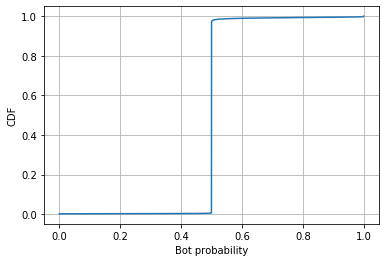

In [69]:
data = dfPiBot.bot_probability
num_bins = round(len(data)/10)
counts, bin_edges = np.histogram (data, bins=num_bins, normed=True)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])
plt.grid()
plt.xlabel("Bot probability")
plt.ylabel("CDF")

In [72]:
nlow = len(dfPiBot[dfPiBot.bot_probability<0.5])
nhigh = len(dfPiBot[dfPiBot.bot_probability>0.5])
nmid = len(dfPiBot[dfPiBot.bot_probability==0.5])
print("%s users bot prob<0.5\n%s users bot prob>0.5\n%s users bot prob=0.5\n"%(nlow,nmid,nhigh))

828 users bot prob<0.5
102663 users bot prob>0.5
4160 users bot prob=0.5



Text(0.5, 1.0, 'No 0.5 probability users')

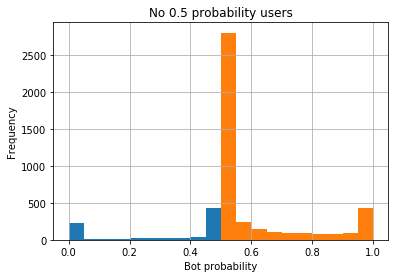

In [71]:
plt.hist(dfPiBot.bot_probability[dfPiBot.bot_probability<0.5]);
plt.hist(dfPiBot.bot_probability[dfPiBot.bot_probability>0.5]);
plt.grid()
plt.xlabel("Bot probability")
plt.ylabel("Frequency")
plt.title("No 0.5 probability users")